In [166]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [167]:
def print_missing(df, col):
    tot = len(df.index)
    missing = len(df.loc[df[col].isna()])
    print(
        f"There are {missing} missing values out of {tot} values for the column {col}"
    )


def drop_inplace_ifexist(df, col):
    if col in list(df.columns):
        df.drop(col, inplace=True, axis=1)

In [168]:
# Importing data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# As usual it will prove useful to merge the datasets when analyzing features
full_df = pd.concat([train_df, test_df])

# Exploratory Data Analysis

We start by analyzing the data, finding correlations, connections. Let us start by looking at the columns.

In [169]:
display(list(full_df.columns))
full_df.info()

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


Text(0.5, 1.0, 'Heatmap of missing values')

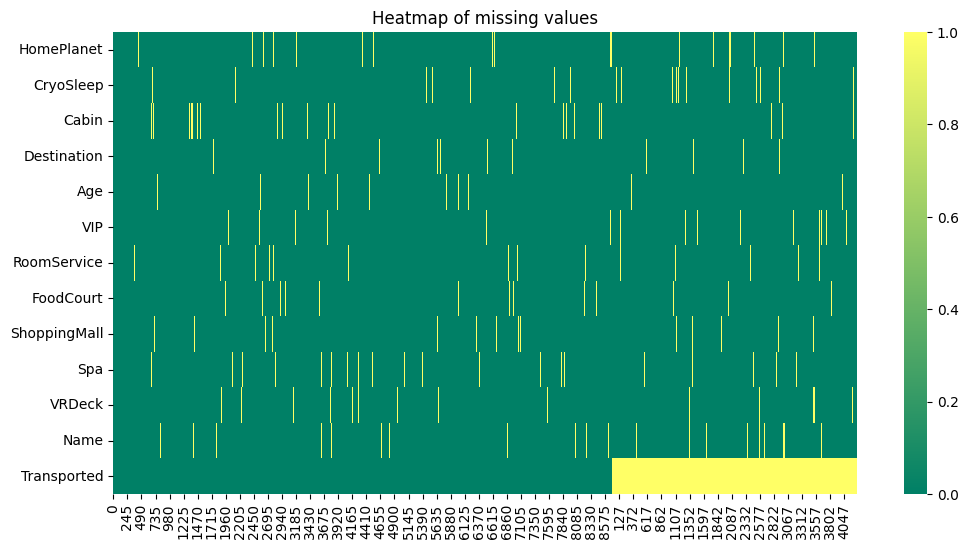

In [170]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    full_df[full_df.columns[full_df.isna().any()].tolist()].isna().T, cmap="summer"
)
plt.title("Heatmap of missing values")

In [171]:
for col in list(full_df.columns):
    print_missing(full_df, col)

There are 0 missing values out of 12970 values for the column PassengerId
There are 288 missing values out of 12970 values for the column HomePlanet
There are 310 missing values out of 12970 values for the column CryoSleep
There are 299 missing values out of 12970 values for the column Cabin
There are 274 missing values out of 12970 values for the column Destination
There are 270 missing values out of 12970 values for the column Age
There are 296 missing values out of 12970 values for the column VIP
There are 263 missing values out of 12970 values for the column RoomService
There are 289 missing values out of 12970 values for the column FoodCourt
There are 306 missing values out of 12970 values for the column ShoppingMall
There are 284 missing values out of 12970 values for the column Spa
There are 268 missing values out of 12970 values for the column VRDeck
There are 294 missing values out of 12970 values for the column Name
There are 4277 missing values out of 12970 values for the co

This dataset contains many null entries (2% on average) which we will have to consider and fill. First let us summarize the various columns and whether they will prove useful:

1. HomePlanet: a label on the origin of the passenger, can be Earth, Europa or Mars. It might be easier to count missing values as its own label and see how it correlates with other features. Possible onehot encoding.
2. CryoSleep: bool indicating whether the passenger is in cryosleep. If so, confined to cabin. Possibly very correlated to transport.
3. Cabin: Deck/Num/Side format. Should extract each of these informations, position on the ship will likely correlate to transport. Compare missing values to cryosleep.
4. Destination: a label on the destination of the passenger, can be '55 Cancri e', 'PSO J318.5-22', or 'TRAPPIST-1e'. Treat missing values like HomePlanet.
5. Age: Float, should replace missing value with median age (possibly per correlated grouping with other feature). Also maybe slice per decile.
6. VIP: Boolean, could infer missing value from correlations with other class indicators (cabin, age, billing)
7. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Floats, missing value can be inferred from cryosleep status and median amount per age group?
8. Name: Firstname Lastname, can get family by family name, check correlations with cabin.
9. PassengerId: Group_Nb, all filled

## Information extraction

In [172]:
# Temporary filling NaN
full_df.fillna({"Cabin": "Z/9999/Z"}, inplace=True)


def get_cabin_info(df):
    df["HasCabin"] = -df["Cabin"].isna()
    df["CabinDeck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["CabinNum"] = df["Cabin"].apply(lambda x: x.split("/")[1]).astype(int)
    df["CabinSide"] = df["Cabin"].apply(lambda x: x.split("/")[2])


get_cabin_info(full_df)

full_df.loc[full_df["Cabin"] == "Z/9999/Z", "Cabin"] = np.nan
full_df.loc[full_df["CabinDeck"] == "Z", "CabinDeck"] = np.nan
full_df.loc[full_df["CabinNum"] == 9999, "CabinNum"] = np.nan
full_df.loc[full_df["CabinSide"] == "Z", "CabinSide"] = np.nan

full_df.drop("Cabin", inplace=True, axis=1)

In [173]:
def get_passenger_info(df):
    df["PassengerGroup"] = df["PassengerId"].str.slice(0, 4).astype("int32")
    df["PassengerGroupNb"] = df["PassengerId"].str.slice(5, 7).astype("int32")
    df["GroupSize"] = df["PassengerGroup"].map(
        lambda x: df["PassengerGroup"].value_counts()[x]
    )


get_passenger_info(full_df)

In [174]:
def get_total_bill(df):
    df["TotalBill"] = (
        df["FoodCourt"]
        + df["VRDeck"]
        + df["ShoppingMall"]
        + df["RoomService"]
        + df["Spa"]
    )


get_total_bill(full_df)

In [175]:
def get_first_last_name(df):
    df["FirstName"] = df["Name"].apply(
        lambda x: x.split(" ")[0] if not pd.isnull(x) else x
    )
    df["LastName"] = df["Name"].apply(
        lambda x: x.split(" ")[1] if not pd.isnull(x) else x
    )


get_first_last_name(full_df)

In [176]:
groups_family = full_df.groupby(["LastName", "PassengerGroup"])["PassengerId"].count()


def get_number_family(df):
    df["NumberFamilyGroup"] = 0.0
    df["NumberFamilyGroup"] = df.apply(
        lambda row: (
            groups_family.loc[row["LastName"], row["PassengerGroup"]] - 1
            if not pd.isnull(row["LastName"]) and not pd.isnull(row["PassengerGroup"])
            else np.nan
        ),
        axis=1,
    )
    df["HasFamily"] = df["NumberFamilyGroup"] > 0


get_number_family(full_df)

In [177]:
def define_children(df):
    df["IsChild"] = df["Age"] <= 12


def break_age_quantile(df, col, n):
    df[col + "_cut"] = pd.qcut(df[col], n, duplicates="drop")


define_children(full_df)
# break_age_quantile(full_df, "Age", 10)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HasCabin,CabinNum,PassengerGroup,PassengerGroupNb,GroupSize,TotalBill,NumberFamilyGroup,HasFamily,IsChild
Age,1.000000,0.067300,0.124447,0.034959,0.118992,0.101441,NaN,-0.137871,-0.013590,-0.129864,-0.178402,0.181097,-0.153617,-0.116760,-0.534468
RoomService,0.067300,1.000000,-0.020146,0.057402,0.008936,-0.023847,NaN,-0.007937,-0.000886,-0.025118,-0.033886,0.220580,-0.034756,-0.014165,-0.107485
FoodCourt,0.124447,-0.020146,1.000000,-0.001589,0.228990,0.244279,NaN,-0.180268,-0.010845,0.017462,0.019643,0.749670,0.013897,0.048907,-0.089529
ShoppingMall,0.034959,0.057402,-0.001589,1.000000,0.010504,0.004485,NaN,-0.009483,-0.006561,-0.034069,-0.039131,0.231839,-0.045959,-0.037508,-0.092751
Spa,0.118992,0.008936,0.228990,0.010504,1.000000,0.149874,NaN,-0.132617,-0.006324,0.019822,0.017875,0.598352,0.021216,0.039492,-0.085554
VRDeck,0.101441,-0.023847,0.244279,0.004485,0.149874,1.000000,NaN,-0.138885,0.005975,0.010005,0.009689,0.588481,0.017674,0.041979,-0.080925
HasCabin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CabinNum,-0.137871,-0.007937,-0.180268,-0.009483,-0.132617,-0.138885,NaN,1.000000,0.682806,-0.044230,-0.055769,-0.218713,-0.061908,-0.121401,0.077142
PassengerGroup,-0.013590,-0.000886,-0.010845,-0.006561,-0.006324,0.005975,NaN,0.682806,1.000000,0.005961,0.007881,-0.010289,0.007337,-0.012093,-0.006107
PassengerGroupNb,-0.129864,-0.025118,0.017462,-0.034069,0.019822,0.010005,NaN,-0.044230,0.005961,1.000000,0.756404,0.010897,0.652843,0.494869,0.268091


<Axes: >

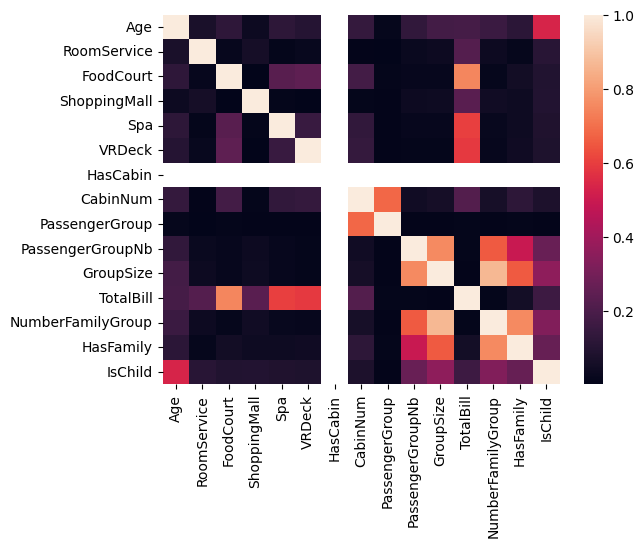

In [178]:
correlations_numeric = full_df.corr(numeric_only=True)
display(correlations_numeric)
sns.heatmap(correlations_numeric.abs())

We see that the cabin deck gives us some idea of the home planet. People in cabin A,B,C,T are from Europa and vice versa. People in cabin E can be from anywhere, cabin F from Earth or Mars and cabin G from Earth

In [179]:
display(full_df.groupby(["HomePlanet", "CabinDeck"])["CabinDeck"].count())

HomePlanet  CabinDeck
Earth       E             583
            F            2426
            G            3700
Europa      A             346
            B            1124
            C            1081
            D             296
            E             197
            T              10
Mars        D             406
            E             508
            F            1713
Name: CabinDeck, dtype: int64

We have managed to establish that there are groups highly correlated to families. Now we check the following assumptions put forward in this [discusion](https://www.kaggle.com/competitions/spaceship-titanic/discussion/315987). Those that are true on assigned data will be used as rules to fill said data:

- People in the same PassengerGroup have the same CabinSide (and CabinDeck?)
- People in the same PassengerGroup have the same HomePlanet
- People with the same LastName have the same HomePlanet
- No bills for Children, CryoSleep
- People in CabinDeck A,B,C,T are from Europa
- People in CabinDeck G are from Earth
- People in the same group and same family name are in the same cabin

In [180]:
match_group_side = (
    full_df[["PassengerGroup", "CabinSide"]]
    .dropna()
    .groupby(["PassengerGroup"])["CabinSide"]
    .nunique()
    == 1
).all()
print(f"Matching between PassengerGroup and CabinSide: {match_group_side}")

match_group_planet = (
    full_df[["PassengerGroup", "HomePlanet"]]
    .dropna()
    .groupby(["PassengerGroup"])["HomePlanet"]
    .nunique()
    == 1
).all()
print(f"Matching between PassengerGroup and HomePlanet: {match_group_planet}")

match_name_planet = (
    full_df[["LastName", "HomePlanet"]]
    .dropna()
    .groupby(["LastName"])["HomePlanet"]
    .nunique()
    == 1
).all()
print(f"Matching between LastName and HomePlanet: {match_name_planet}")

match_bills_children = (
    full_df.loc[full_df["IsChild"], "TotalBill"].dropna() == 0.0
).all()
print(f"Matching between Children and NoBills: {match_bills_children}")

temp_df = full_df[["CryoSleep", "TotalBill"]].dropna()
match_bills_cryosleep = (temp_df.loc[temp_df["CryoSleep"], "TotalBill"] == 0.0).all()
print(f"Matching between CryoSleep and NoBills: {match_bills_cryosleep}")

temp_df = full_df[["CabinDeck", "HomePlanet"]].dropna()
match_cabin_europa = (
    temp_df.loc[temp_df["CabinDeck"].isin(["A", "B", "C", "T"]), "HomePlanet"]
    == "Europa"
).all()
print(f"Matching between CabinDeck and HomePlanet (Europa): {match_cabin_europa}")

temp_df = full_df[["CabinDeck", "HomePlanet"]].dropna()
match_cabin_earth = (
    temp_df.loc[temp_df["CabinDeck"] == "G", "HomePlanet"] == "Earth"
).all()
print(f"Matching between CabinDeck and HomePlanet (Earth): {match_cabin_earth}")

Matching between PassengerGroup and CabinSide: True
Matching between PassengerGroup and HomePlanet: True
Matching between LastName and HomePlanet: True
Matching between Children and NoBills: True
Matching between CryoSleep and NoBills: True
Matching between CabinDeck and HomePlanet (Europa): True
Matching between CabinDeck and HomePlanet (Earth): True


In [181]:
# We define a cabin side per passenger group
groups_to_homeplanet = full_df.groupby("PassengerGroup")["HomePlanet"].first()
last_name_to_homeplanet = full_df.groupby("LastName")["HomePlanet"].first()
first_name_to_homeplanet = full_df.groupby("FirstName")["HomePlanet"].first()


def fill_homeplanet(row):
    if not pd.isnull(row["HomePlanet"]):
        return row["HomePlanet"]

    if not pd.isnull(groups_to_homeplanet[row["PassengerGroup"]]):
        return groups_to_homeplanet[row["PassengerGroup"]]

    if not pd.isnull(row["LastName"]) and not pd.isnull(
        last_name_to_homeplanet[row["LastName"]]
    ):
        return last_name_to_homeplanet[row["LastName"]]

    if not pd.isnull(row["FirstName"]) and not pd.isnull(
        first_name_to_homeplanet[row["FirstName"]]
    ):
        return first_name_to_homeplanet[row["FirstName"]]

    if row["CabinDeck"] in ["A", "B", "C", "T"]:
        return "Europa"
    if row["CabinDeck"] == "G":
        return "Earth"
    return np.nan


full_df["HomePlanetFilled"] = full_df.apply(fill_homeplanet, axis=1)
print_missing(full_df, "HomePlanetFilled")

There are 5 missing values out of 12970 values for the column HomePlanetFilled


The homeplanet feature is almost fully filled. There are 5 remaining unknowns which match those with no name given. To narrow down the filling, we also used the first name in last resort to fill the homeplanet, using someone else's information with the same first name. They all come from Trappist-1e

In [182]:
full_df.loc[
    full_df["HomePlanetFilled"].isna(), ["HomePlanetFilled", "Destination", "CabinDeck"]
]

,HomePlanetFilled,Destination,CabinDeck
2274,NaN,TRAPPIST-1e,D
3091,NaN,TRAPPIST-1e,F
4548,NaN,TRAPPIST-1e,F
5762,NaN,TRAPPIST-1e,F
3858,NaN,TRAPPIST-1e,F


<Axes: xlabel='HomePlanetFilled', ylabel='Destination'>

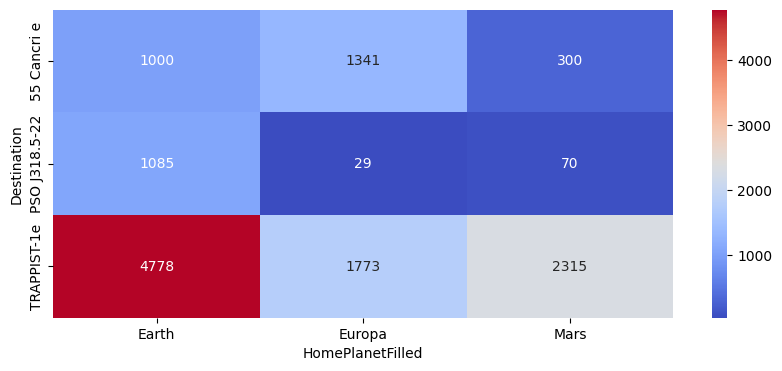

In [183]:
df_gb_hp_dest = (
    full_df.groupby(["HomePlanetFilled", "Destination"])["Destination"]
    .size()
    .unstack()
    .fillna(0)
)
plt.figure(figsize=(10, 4))
sns.heatmap(df_gb_hp_dest.T, annot=True, fmt="g", cmap="coolwarm")

Most people from TRAPPIST-1e come from Earth so it's a safe choice, except the person from Deck D as we can see that no one on CabinDeck D comes from Earth (wee then choose Mars)

<Axes: xlabel='HomePlanetFilled', ylabel='CabinDeck'>

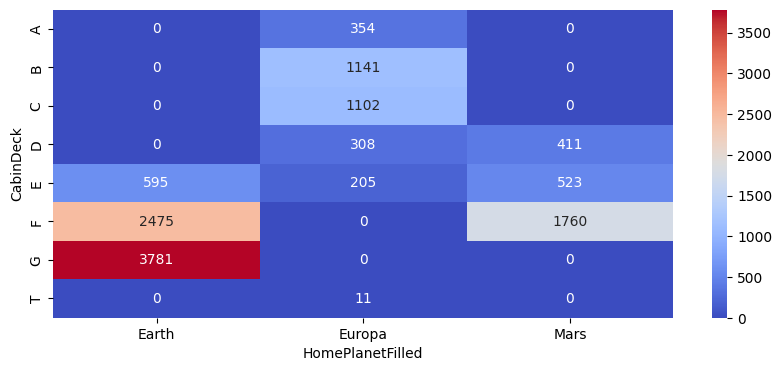

In [184]:
df_gb_hp_cd = (
    full_df.groupby(["HomePlanetFilled", "CabinDeck"])["CabinDeck"]
    .size()
    .unstack()
    .fillna(0)
)
plt.figure(figsize=(10, 4))
sns.heatmap(df_gb_hp_cd.T, annot=True, fmt="g", cmap="coolwarm")

In [185]:
full_df.loc[
    (full_df["HomePlanetFilled"].isna()) & (full_df["CabinDeck"] == "D"),
    "HomePlanetFilled",
] = "Mars"
full_df.loc[
    (full_df["HomePlanetFilled"].isna()) & (full_df["CabinDeck"] != "D"),
    "HomePlanetFilled",
] = "Earth"

In [186]:
print_missing(full_df, "HomePlanetFilled")

drop_inplace_ifexist(full_df, "HomePlanet")

There are 0 missing values out of 12970 values for the column HomePlanetFilled


In [187]:
# We set the bill to 0 for children and cryosleep people
for c1 in ["IsChild", "CryoSleep"]:
    for c2 in [
        "TotalBill",
        "VRDeck",
        "Spa",
        "FoodCourt",
        "RoomService",
        "ShoppingMall",
    ]:
        full_df.loc[full_df[c1].fillna(False), c2] = 0

# Similarly, by definition of CryoSleep, if someone's bill is positive they cannot be sleeping
full_df.loc[full_df["TotalBill"] > 0, "CryoSleep"] = False

/tmp/ipykernel_51149/2582643436.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_df.loc[full_df[c1].fillna(False), c2] = 0


In [188]:
for col in full_df.columns:
    print_missing(full_df, col)

There are 0 missing values out of 12970 values for the column PassengerId
There are 153 missing values out of 12970 values for the column CryoSleep
There are 274 missing values out of 12970 values for the column Destination
There are 270 missing values out of 12970 values for the column Age
There are 296 missing values out of 12970 values for the column VIP
There are 162 missing values out of 12970 values for the column RoomService
There are 171 missing values out of 12970 values for the column FoodCourt
There are 163 missing values out of 12970 values for the column ShoppingMall
There are 166 missing values out of 12970 values for the column Spa
There are 150 missing values out of 12970 values for the column VRDeck
There are 294 missing values out of 12970 values for the column Name
There are 4277 missing values out of 12970 values for the column Transported
There are 0 missing values out of 12970 values for the column HasCabin
There are 299 missing values out of 12970 values for the 

In [189]:
# There are no VIP from Earth so we set it to zero
display(
    full_df.loc[full_df["HomePlanetFilled"] == "Earth", ["VIP", "PassengerId"]]
    .groupby("VIP")
    .count()
)

full_df.loc[full_df["HomePlanetFilled"] == "Earth", "VIP"] = False

,PassengerId
VIP,
False,6855


In [190]:
# People with no Bill which aren't a child and aren't in cryosleep go to Trappist
display(
    set(
        list(
            full_df.loc[
                (full_df["IsChild"] == False)
                & (full_df["CryoSleep"] == False)
                & (full_df["TotalBill"] == 0)
            ]["Destination"]
        )
    )
)

full_df["DestinationFilled"] = full_df["Destination"]

full_df.loc[
    (full_df["IsChild"] == False)
    & (full_df["CryoSleep"] == False)
    & (full_df["TotalBill"] == 0),
    "DestinationFilled",
] = "TRAPPIST-1e"

{'TRAPPIST-1e', nan}

In [191]:
# A few more connections

# No Earth VIPs
display(full_df.loc[full_df["HomePlanetFilled"] == "Earth", "VIP"].dropna().any())
full_df.loc[full_df["HomePlanetFilled"] == "Earth", "VIP"] = False

# Europa VIP are always aged greater than 25 so younger people should not be VIPs
display(
    (
        full_df.loc[
            (full_df["HomePlanetFilled"] == "Europa") & (full_df["VIP"] == True), "Age"
        ]
        < 25
    ).any()
)
full_df.loc[
    (full_df["HomePlanetFilled"] == "Europa") & (full_df["Age"] < 25), "VIP"
] = False

False

False

In [192]:
for col in full_df.columns:
    print_missing(full_df, col)

There are 0 missing values out of 12970 values for the column PassengerId
There are 153 missing values out of 12970 values for the column CryoSleep
There are 274 missing values out of 12970 values for the column Destination
There are 270 missing values out of 12970 values for the column Age
There are 128 missing values out of 12970 values for the column VIP
There are 162 missing values out of 12970 values for the column RoomService
There are 171 missing values out of 12970 values for the column FoodCourt
There are 163 missing values out of 12970 values for the column ShoppingMall
There are 166 missing values out of 12970 values for the column Spa
There are 150 missing values out of 12970 values for the column VRDeck
There are 294 missing values out of 12970 values for the column Name
There are 4277 missing values out of 12970 values for the column Transported
There are 0 missing values out of 12970 values for the column HasCabin
There are 299 missing values out of 12970 values for the 

Now let's apply a collection of ideas gathered from [here](https://www.kaggle.com/competitions/spaceship-titanic/discussion/332081). First, we can determine safe and dangerous decks from analyzing the transportation data.

In [193]:
list_decks = set(list(full_df["CabinDeck"].dropna()))
count_survival_rate_decks = full_df.groupby(["CabinDeck", "Transported"])[
    "PassengerId"
].count()
survival_rate_decks = {
    deck: count_survival_rate_decks[deck, False]
    / (count_survival_rate_decks[deck, True] + count_survival_rate_decks[deck, False])
    for deck in list_decks
}
display(survival_rate_decks)
dangerous_decks = [k for k, v in survival_rate_decks.items() if v < 0.5]
display(dangerous_decks)

full_df["DangerousDeck"] = full_df["CabinDeck"].isin(dangerous_decks)

{'B': 0.26572528883183566,
 'E': 0.6426940639269406,
 'D': 0.5669456066945606,
 'G': 0.4837827276279797,
 'T': 0.8,
 'F': 0.5601288475304224,
 'A': 0.50390625,
 'C': 0.31994645247657294}

['B', 'G', 'C']

More advice on feature engineering:
- drop VIP feature - 0.02% increase
- create an expenditure feature that sums the total money spent across the 5 amenities - 0.5% increase
- create expenditure feature and drop the 5 amenities (RoomService, …,VRDeck) - 4.7% decrease
- create a cabin deck feature (A,B,…,T) - 0.35% increase
- create a cabin side feature (P/S) - 0.9% increase
- create a group size feature from the PassengerId column - 0.1% increase
- create a no spending binary feature that is 1 if no money was spent and 0 otherwise - 0.2% increase
- Create a solo feature that tracks if passenger was travelling on their own (from PassengerId) - 0.2% increase
- Create cabin region features according to chunks of 300 passengers (see here for details) - 0.2% increase-
- create a family size feature from last name - 0.0% change
- create binary age features for 0-18 yo, 18-25 yo, 25+ yo - 0.02% increase
- same as above but drop the age column - 0.4% drop

Conclusions:

1. create total expenditure, cabin deck and cabin side features - these are very helpful
2. group size, solo, no_spending and cabin regions also help a bit


Let's also fill values per traveling group (median of the group's value)

In [194]:
# We fill after grouping by a column using the median
def fill_na_per_column(df, col, group_field="PassengerGroup"):
    # numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    # numeric_tmp = df.select_dtypes(include=numerics)
    # categorical_tmp = df.select_dtypes(exclude=numerics)

    # for col in numeric_tmp.columns:
    df[col] = df[col].fillna(df.groupby(group_field)[col].transform("median"))


[
    fill_na_per_column(full_df, col)
    for col in [
        "Age",
        "RoomService",
        "FoodCourt",
        "ShoppingMall",
        "Spa",
        "VRDeck",
        "TotalBill",
    ]
]
# Those still NA at this point are in single-passenger groups and can be safely put to the median of the entire column
for col in [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalBill",
]:
    full_df[col] = full_df[col].fillna(full_df[col].median())

In [195]:
for col in full_df.columns:
    print_missing(full_df, col)

There are 0 missing values out of 12970 values for the column PassengerId
There are 153 missing values out of 12970 values for the column CryoSleep
There are 274 missing values out of 12970 values for the column Destination
There are 0 missing values out of 12970 values for the column Age
There are 128 missing values out of 12970 values for the column VIP
There are 0 missing values out of 12970 values for the column RoomService
There are 0 missing values out of 12970 values for the column FoodCourt
There are 0 missing values out of 12970 values for the column ShoppingMall
There are 0 missing values out of 12970 values for the column Spa
There are 0 missing values out of 12970 values for the column VRDeck
There are 294 missing values out of 12970 values for the column Name
There are 4277 missing values out of 12970 values for the column Transported
There are 0 missing values out of 12970 values for the column HasCabin
There are 299 missing values out of 12970 values for the column Cabin

Now we follow the procedure in [here](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide#Missing-values) to fill the missing cabin numbers based on their relationship with passenger group. First we need to fill missing CabinDeck

In [196]:
print_missing(full_df, "CabinDeck")

# Groups tend to be on the same deck
CabinDeckMajorityVoteGroup = (
    full_df.groupby("PassengerGroup")["CabinDeck"]
    .agg(pd.Series.mode)
    .apply(lambda x: x[0] if len(x) > 0 else np.nan)
)
full_df["CabinDeckFilledTmp"] = full_df.apply(
    lambda row: CabinDeckMajorityVoteGroup[row["PassengerGroup"]]
    if pd.isnull(row["CabinDeck"])
    else row["CabinDeck"],
    axis=1,
)

print_missing(full_df, "CabinDeckFilledTmp")

There are 299 missing values out of 12970 values for the column CabinDeck
There are 162 missing values out of 12970 values for the column CabinDeckFilledTmp


For the next step, we will fill the deck by mode of HomePlanet, Destination, Solo travel. We need to make sure we have no NAN for these. The destination we just fill with the most popular.

In [197]:
most_popular_destination = full_df["DestinationFilled"].value_counts().idxmax()
full_df.loc[full_df["DestinationFilled"].isna(), "DestinationFilled"] = (
    most_popular_destination
)

print_missing(full_df, "DestinationFilled")

drop_inplace_ifexist(full_df, "Destination")

There are 0 missing values out of 12970 values for the column DestinationFilled


In [198]:
full_df["Solo"] = full_df["GroupSize"] == 1

full_df.groupby(
    ["HomePlanetFilled", "DestinationFilled", "Solo", "CabinDeckFilledTmp"]
)["CabinDeckFilledTmp"].size().unstack().fillna(0)

CabinDeckFilledTmp                            A      B      C      D      E  \
HomePlanetFilled DestinationFilled Solo                                       
Earth            55 Cancri e       False    0.0    0.0    0.0    0.0   20.0   
                                   True     0.0    0.0    0.0    0.0   47.0   
                 PSO J318.5-22     False    0.0    0.0    0.0    0.0   18.0   
                                   True     0.0    0.0    0.0    0.0   25.0   
                 TRAPPIST-1e       False    0.0    0.0    0.0    0.0  133.0   
                                   True     0.0    0.0    0.0    0.0  356.0   
Europa           55 Cancri e       False   96.0  377.0  313.0   59.0   35.0   
                                   True    67.0  141.0  159.0   46.0   34.0   
                 PSO J318.5-22     False    2.0    5.0   11.0    0.0    0.0   
                                   True     0.0    0.0   10.0    0.0    0.0   
                 TRAPPIST-1e       False  152.0  459.0  428.0  120.0   53.0   
                                   True    44.0  179.0  201.0   86.0   84.0   
Mars             55 Cancri e       False    0.0    0.0    0.0   32.0   15.0   
                                   True     0.0    0.0    0.0   40.0   16.0   
                 PSO J318.5-22     False    0.0    0.0    0.0    8.0    9.0   
                                   True     0.0    0.0    0.0    9.0    7.0   
                 TRAPPIST-1e       False    0.0    0.0    0.0  168.0  219.0   
                                   True     0.0    0.0    0.0  162.0  263.0   

CabinDeckFilledTmp                             F       G    T  
HomePlanetFilled DestinationFilled Solo                        
Earth            55 Cancri e       False    90.0   272.0  0.0  
                                   True    289.0   269.0  0.0  
                 PSO J318.5-22     False    67.0   230.0  0.0  
                                   True    262.0   466.0  0.0  
                 TRAPPIST-1e       False   438.0  1075.0  0.0  
                                   True   1349.0  1509.0  0.0  
Europa           55 Cancri e       False     0.0     0.0  2.0  
                                   True      0.0     0.0  0.0  
                 PSO J318.5-22     False     0.0     0.0  0.0  
                                   True      0.0     0.0  0.0  
                 TRAPPIST-1e       False     0.0     0.0  1.0  
                                   True      0.0     0.0  8.0  
Mars             55 Cancri e       False   104.0     0.0  0.0  
                                   True     92.0     0.0  0.0  
                 PSO J318.5-22     False    14.0     0.0  0.0  
                                   True     21.0     0.0  0.0  
                 TRAPPIST-1e       False   798.0     0.0  0.0  
                                   True    744.0     0.0  0.0

- Passengers from Mars are most likely in deck F.
- Passengers from Europa are (more or less) most likely in deck C if travelling solo and deck B otherwise.
- Passengers from Earth are (more or less) most likely in deck G.


In [199]:
# We fill by the mode of these groups
CabinDeckMajorityVoteOther = (
    full_df.groupby(["HomePlanetFilled", "DestinationFilled", "Solo"])[
        "CabinDeckFilledTmp"
    ]
    .agg(pd.Series.mode)
    .apply(lambda x: x[0] if len(x) > 0 else np.nan)
)
full_df["CabinDeckFilled"] = full_df.apply(
    lambda row: CabinDeckMajorityVoteOther[
        (row["HomePlanetFilled"], row["DestinationFilled"], row["Solo"])
    ]
    if pd.isnull(row["CabinDeckFilledTmp"])
    else row["CabinDeckFilledTmp"],
    axis=1,
)

In [200]:
print_missing(full_df, "CabinDeckFilled")

drop_inplace_ifexist(full_df, "CabinDeck")
drop_inplace_ifexist(full_df, "CabinDeckFilledTmp")

There are 0 missing values out of 12970 values for the column CabinDeckFilled


Text(0.5, 1.0, 'CabinNumber vs PassengerGroup coloured by PassengerGroup')

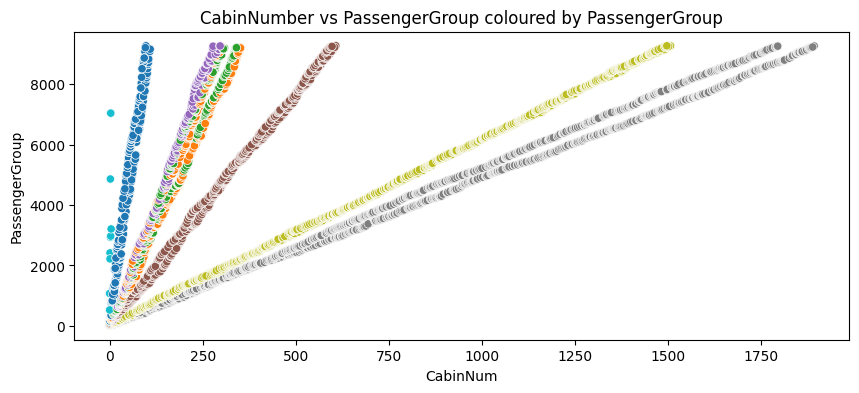

In [201]:
plt.figure(figsize=(10, 4))
tmp_df = full_df.loc[
    -full_df["CabinNum"].isna(), ["CabinNum", "PassengerGroup", "CabinDeckFilled"]
]
sns.scatterplot(
    x=tmp_df["CabinNum"],
    y=tmp_df["PassengerGroup"],
    c=LabelEncoder().fit_transform(tmp_df["CabinDeckFilled"]),
    cmap="tab10",
)
plt.title("CabinNumber vs PassengerGroup coloured by PassengerGroup")

We see a linear relation between CabinNumber and PassengerGroup, can we fit it?

In [202]:
from sklearn.linear_model import LinearRegression

# Missing Cabin Numbers before
CN_before = full_df["CabinNum"].isna().sum()
decks = list(set(full_df["CabinDeckFilled"]))
for deck in decks:
    X_CN = full_df.loc[
        (-full_df["CabinNum"].isna()) & (full_df["CabinDeckFilled"] == deck),
        "PassengerGroup",
    ]
    y_CN = full_df.loc[
        (-full_df["CabinNum"].isna()) & (full_df["CabinDeckFilled"] == deck), "CabinNum"
    ]
    X_test_CN = full_df.loc[
        (full_df["CabinNum"].isna()) & (full_df["CabinDeckFilled"] == deck),
        "PassengerGroup",
    ]
    if len(X_test_CN) > 0:
        model_CN = LinearRegression()
        model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
        preds_CN = model_CN.predict(X_test_CN.values.reshape(-1, 1))

        full_df.loc[
            (full_df["CabinNum"].isna()) & (full_df["CabinDeckFilled"] == deck),
            "CabinNum",
        ] = preds_CN.astype("int")

print_missing(full_df, "CabinNum")

There are 0 missing values out of 12970 values for the column CabinNum


Let us do a similar thing for CabinSide

In [203]:
# We fill by the mode of these groups
CabinSideMajorityVoteGroup = (
    full_df.groupby("PassengerGroup")["CabinSide"]
    .agg(pd.Series.mode)
    .apply(lambda x: x[0] if len(x) > 0 else np.nan)
)
full_df["CabinSideFilled"] = full_df.apply(
    lambda row: CabinSideMajorityVoteGroup[row["PassengerGroup"]]
    if pd.isnull(row["CabinSide"])
    else row["CabinSide"],
    axis=1,
)

In [204]:
# We fill by the mode of these groups
CabinSideMajorityVoteFamily = (
    full_df.groupby("LastName")["CabinSideFilled"]
    .agg(pd.Series.mode)
    .apply(lambda x: x[0] if len(x) > 0 else np.nan)
)
full_df["CabinSideFilled"] = full_df.apply(
    lambda row: CabinSideMajorityVoteFamily[row["LastName"]]
    if pd.isnull(row["CabinSideFilled"]) and not pd.isnull(row["LastName"])
    else row["CabinSideFilled"],
    axis=1,
)

The last ones corresponds to unnamed passengers, we give them an outlier label

In [215]:
full_df.loc[full_df["CabinSideFilled"].isna(), "CabinSideFilled"] = "Missing"
full_df.loc[full_df["FirstName"].isna(), "FirstName"] = "Missing"
full_df.loc[full_df["LastName"].isna(), "LastName"] = "Missing"
full_df.loc[full_df["NumberFamilyGroup"].isna(), "NumberFamilyGroup"] = "Missing"

[drop_inplace_ifexist(full_df, col) for col in ["CabinSide", "Name"]]

[None, None]

In [216]:
for col in full_df.columns:
    print_missing(full_df, col)

There are 0 missing values out of 12970 values for the column PassengerId
There are 0 missing values out of 12970 values for the column CryoSleep
There are 0 missing values out of 12970 values for the column Age
There are 0 missing values out of 12970 values for the column VIP
There are 0 missing values out of 12970 values for the column RoomService
There are 0 missing values out of 12970 values for the column FoodCourt
There are 0 missing values out of 12970 values for the column ShoppingMall
There are 0 missing values out of 12970 values for the column Spa
There are 0 missing values out of 12970 values for the column VRDeck
There are 4277 missing values out of 12970 values for the column Transported
There are 0 missing values out of 12970 values for the column HasCabin
There are 0 missing values out of 12970 values for the column CabinNum
There are 0 missing values out of 12970 values for the column PassengerGroup
There are 0 missing values out of 12970 values for the column Passenge

In [217]:
display(full_df.groupby("CryoSleep")["Age"].describe())
display(full_df.groupby("HomePlanetFilled")["Age"].describe())
display(full_df.groupby("DestinationFilled")["Age"].describe())
display(full_df.groupby("CabinDeckFilled")["Age"].describe())
display(full_df.groupby("VIP")["Age"].describe())

,count,mean,std,min,25%,50%,75%,max
CryoSleep,,,,,,,,
False,8389.0,29.385624,13.987771,0.0,20.0,27.0,38.0,79.0
True,4581.0,27.495852,14.778809,0.0,18.0,26.0,37.0,78.0


,count,mean,std,min,25%,50%,75%,max
HomePlanetFilled,,,,,,,,
Earth,7016.0,25.905644,14.106751,0.0,18.0,23.0,34.0,79.0
Europa,3201.0,34.284911,12.966443,0.0,26.0,32.0,42.0,79.0
Mars,2753.0,29.413186,14.291253,0.0,20.0,27.0,38.0,76.0


,count,mean,std,min,25%,50%,75%,max
DestinationFilled,,,,,,,,
55 Cancri e,2641.0,29.358387,14.392181,0.0,20.0,27.0,38.0,78.0
PSO J318.5-22,1184.0,27.331926,13.541772,0.0,19.0,24.0,35.0,78.0
TRAPPIST-1e,9145.0,28.712739,14.357632,0.0,19.0,27.0,37.0,79.0


,count,mean,std,min,25%,50%,75%,max
CabinDeckFilled,,,,,,,,
A,361.0,35.475069,13.159046,0.0,27.0,34.0,43.0,73.0
B,1161.0,33.453058,13.198262,0.0,25.0,31.0,42.0,79.0
C,1151.0,34.640313,13.084395,0.0,26.0,33.0,43.0,79.0
D,730.0,33.326712,12.752166,4.0,24.0,31.0,41.0,76.0
E,1334.0,30.099325,12.686540,0.0,21.0,27.0,37.0,79.0
F,4313.0,28.336773,13.329753,0.0,20.0,25.0,36.0,78.0
G,3909.0,24.013686,15.196340,0.0,14.0,22.0,33.0,79.0
T,11.0,35.545455,7.047888,26.0,30.0,35.0,40.0,47.0


,count,mean,std,min,25%,50%,75%,max
VIP,,,,,,,,
False,12697.0,28.547728,14.312008,0.0,19.0,27.0,37.0,79.0
True,273.0,36.644689,11.180757,18.0,28.0,33.0,42.0,73.0


VIP is very unbalance as we just saw so we can fill by the mode. Same for the CryoSleep not filled by previous rules.

In [218]:
full_df.loc[full_df["VIP"].isna(), "VIP"] = full_df["VIP"].mode()[0]

full_df.loc[full_df["CryoSleep"].isna(), "CryoSleep"] = full_df["CryoSleep"].mode()[0]

In [219]:
for col in full_df.columns:
    print_missing(full_df, col)

There are 0 missing values out of 12970 values for the column PassengerId
There are 0 missing values out of 12970 values for the column CryoSleep
There are 0 missing values out of 12970 values for the column Age
There are 0 missing values out of 12970 values for the column VIP
There are 0 missing values out of 12970 values for the column RoomService
There are 0 missing values out of 12970 values for the column FoodCourt
There are 0 missing values out of 12970 values for the column ShoppingMall
There are 0 missing values out of 12970 values for the column Spa
There are 0 missing values out of 12970 values for the column VRDeck
There are 4277 missing values out of 12970 values for the column Transported
There are 0 missing values out of 12970 values for the column HasCabin
There are 0 missing values out of 12970 values for the column CabinNum
There are 0 missing values out of 12970 values for the column PassengerGroup
There are 0 missing values out of 12970 values for the column Passenge

# Preprocessing

In [237]:
full_df_to_encode = full_df


def encode_as_label(df, col):
    return pd.DataFrame(
        {col + "_label": LabelEncoder().fit_transform(df[col])}, index=df.index
    )


def encode_as_onehot(df, col):
    encoded_feat = (
        OneHotEncoder().fit_transform(df[col].values.reshape(-1, 1)).toarray()
    )
    n = df[col].nunique()
    cols = ["{}_{}".format(col, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    return encoded_df


features_onehot = ["HomePlanetFilled", "DestinationFilled", "CabinSideFilled"]
features_labels = ["CabinDeckFilled", "LastName"]

df_labels = [encode_as_label(full_df_to_encode, col) for col in features_labels]
df_onehot = [encode_as_onehot(full_df_to_encode, col) for col in features_onehot]

full_df_encoded = pd.concat([full_df_to_encode, *df_labels, *df_onehot], axis=1)
labels_to_drop = [
    "HomePlanet",
    "Name",
    "FirstName" "HasCabin",
    "CabinSide",
    "PassengerId",
    "HomePlanet",
    "FirstName",
    "NumberFamilyGroup",
]
print(labels_to_drop)
[
    drop_inplace_ifexist(full_df_encoded, col)
    for col in [
        *labels_to_drop,
        *features_onehot,
        *features_labels,
    ]
]
print(full_df_encoded.columns)

['HomePlanet', 'Name', 'FirstNameHasCabin', 'CabinSide', 'PassengerId', 'HomePlanet', 'FirstName', 'NumberFamilyGroup']
Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'HasCabin', 'CabinNum',
       'PassengerGroup', 'PassengerGroupNb', 'GroupSize', 'TotalBill',
       'HasFamily', 'IsChild', 'DangerousDeck', 'Solo',
       'CabinDeckFilled_label', 'LastName_label', 'HomePlanetFilled_1',
       'HomePlanetFilled_2', 'HomePlanetFilled_3', 'DestinationFilled_1',
       'DestinationFilled_2', 'DestinationFilled_3', 'CabinSideFilled_1',
       'CabinSideFilled_2', 'CabinSideFilled_3'],
      dtype='object')


In [263]:
full_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CryoSleep              12970 non-null  object 
 1   Age                    12970 non-null  float64
 2   VIP                    12970 non-null  object 
 3   RoomService            12970 non-null  float64
 4   FoodCourt              12970 non-null  float64
 5   ShoppingMall           12970 non-null  float64
 6   Spa                    12970 non-null  float64
 7   VRDeck                 12970 non-null  float64
 8   Transported            8693 non-null   object 
 9   HasCabin               12970 non-null  bool   
 10  CabinNum               12970 non-null  float64
 11  PassengerGroup         12970 non-null  int32  
 12  PassengerGroupNb       12970 non-null  int32  
 13  GroupSize              12970 non-null  int64  
 14  TotalBill              12970 non-null  float64
 15  HasFamil

In [274]:
X_test = full_df_encoded.loc[full_df_encoded["Transported"].isna()].drop(
    "Transported", axis=1
)
X_train = full_df_encoded.loc[-full_df_encoded["Transported"].isna()].drop(
    "Transported", axis=1
)
X_test_id = full_df.loc[full_df["Transported"].isna()]["PassengerId"].values

y_train = full_df_encoded.loc[-full_df_encoded["Transported"].isna()][
    "Transported"
].astype("bool")

# Simple solution

We start with a very simple RandomForestClassifier, no cross-validation or anything else. We will iterate over this method later. This earned a score of 0.79611 on Kaggle.

In [268]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [277]:
df_output = pd.DataFrame({"PassengerId": X_test_id, "Transported": pred})
df_output.to_csv("NaiveRFC.csv", index=False)